Intgrante:
    DANIEL SANTIAGO URQUINA CASTAÑO
    MARCELA GIRALDO RAMIREZ
    RAFAEL MAURICIO LUNA URIBE
    LUISA FERNANDA VASQUEZ BERNA

# ANALITICA DE DATOS CON INTELIGENCIA ARTIFICIAL

# EDA con datos EPM

**Universidad de los Andes**

2024

---

Juan C. Vega MsC

Intgrante:
    DANIEL SANTIAGO URQUINA CASTAÑO
    MARCELA GIRALDO RAMIREZ
    RAFAEL MAURICIO LUNA URIBE
    LUISA FERNANDA VASQUEZ BERNA

# PREDICCION DE ENSA A PARTIR DE DEEP LEARNING para EL MES DE MAYO

**Necesidad:** modelar la relación existente entre el registro de temperatura de las instalaciones (puntos de servicio) del Área Metropolitana de Medellín de acuerdo con tomas de drones termográficos (por realizar) y el consumo de energía de las instalaciones, así como el registro histórico de defraudaciones de dicho servicio (fraudes).

In [ ]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer
from matplotlib import pyplot as plt
import tensorflow as tf
import seaborn as sns

In [ ]:
# Montar Google Drive (asumiendo que los datos están allí)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cargar los datos
file_path = '/content/drive/MyDrive/Local EPM dIplomado/BD_maestro.csv'  # Ajusta a la ubicación de tu archivo CSV
datos_Maestro = pd.read_csv(file_path)

In [ ]:
# Convertir la columna 'fecha' a datetime
datos_Maestro['fecha'] = pd.to_datetime(datos_Maestro['fecha'])

In [ ]:
datos_Maestro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fecha              168 non-null    datetime64[ns]
 1   oni                168 non-null    float64       
 2   PIB_real           168 non-null    float64       
 3   PIB_(%)_real       168 non-null    float64       
 4   PIB__corriente     168 non-null    float64       
 5   PIB_(%)_corriente  168 non-null    float64       
 6   wti_usd_barril     168 non-null    int64         
 7   hh_usd_mllbtu      168 non-null    float64       
 8   Panama             168 non-null    int64         
 9   ENSA               168 non-null    int64         
 10  dummy              168 non-null    int64         
dtypes: datetime64[ns](1), float64(6), int64(4)
memory usage: 14.6 KB


In [ ]:
datos_Maestro.describe()

,fecha,oni,PIB_real,PIB_(%)_real,PIB__corriente,PIB_(%)_corriente,wti_usd_barril,hh_usd_mllbtu,Panama,ENSA,dummy
count,168,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.0
mean,2016-12-15 16:17:08.571428608,-0.042262,41.325214,0.056429,55.482143,0.085714,71.732143,3.432738,806.142857,283.601190,0.0
min,2010-01-01 00:00:00,-1.700000,25.066000,-0.180000,29.440000,-0.180000,17.000000,1.600000,529.000000,195.000000,0.0
25%,2013-06-23 12:00:00,-0.700000,32.745000,0.050000,45.600000,0.070000,52.000000,2.600000,706.750000,254.750000,0.0
50%,2016-12-16 12:00:00,-0.200000,37.277000,0.060000,55.964000,0.090000,72.000000,3.000000,827.500000,289.000000,0.0
75%,2020-06-08 12:00:00,0.500000,41.799000,0.100000,64.929000,0.140000,89.750000,4.100000,894.000000,312.000000,0.0
max,2023-12-01 00:00:00,2.600000,78.591000,0.160000,76.523000,0.180000,115.000000,8.800000,1067.000000,361.000000,0.0
std,NaN,0.903917,15.107150,0.073764,13.913906,0.087003,22.023252,1.273004,123.033382,38.216393,0.0


In [ ]:
# Encontrar NaNs y valores duplicados en datos_Maestro

print('hay {} valores missing o NaNs en datos_Maestro.'
      .format(datos_Maestro.isnull().values.sum()))

temp_datos = datos_Maestro.duplicated(keep='first').sum()

print('hay {} filas duplicadas en datos_Maestro revisando todas las columnas.'
      .format(temp_datos))

hay 0 valores missing o NaNs en datos_Maestro.
hay 0 filas duplicadas en datos_Maestro revisando todas las columnas.


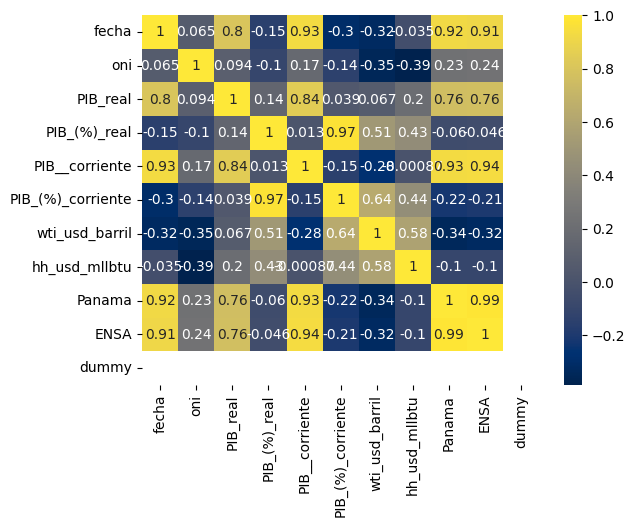

In [ ]:
# EDA básico: matriz de correlación y gráficas
sns.heatmap(datos_Maestro.corr(), annot=True, cmap='cividis')
plt.show()

In [ ]:

correlations = datos_Maestro.corr(method='pearson')
print(correlations['ENSA'].sort_values(ascending=False).to_string())

ENSA                 1.000000
Panama               0.986787
PIB__corriente       0.939072
fecha                0.909834
PIB_real             0.764443
oni                  0.239502
PIB_(%)_real        -0.045753
hh_usd_mllbtu       -0.103195
PIB_(%)_corriente   -0.206166
wti_usd_barril      -0.324960
dummy                     NaN


In [ ]:
datos_Maestro.dtypes

fecha                datetime64[ns]
oni                         float64
PIB_real                    float64
PIB_(%)_real                float64
PIB__corriente              float64
PIB_(%)_corriente           float64
wti_usd_barril                int64
hh_usd_mllbtu               float64
Panama                        int64
ENSA                          int64
dummy                         int64
dtype: object

In [ ]:
# Definir una funcion para graficar los diferentes tipos de time-series

def plot_series(df=None, column=None, series=pd.Series([]),
                label=None, ylabel=None, title=None, start=0, end=None):

    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

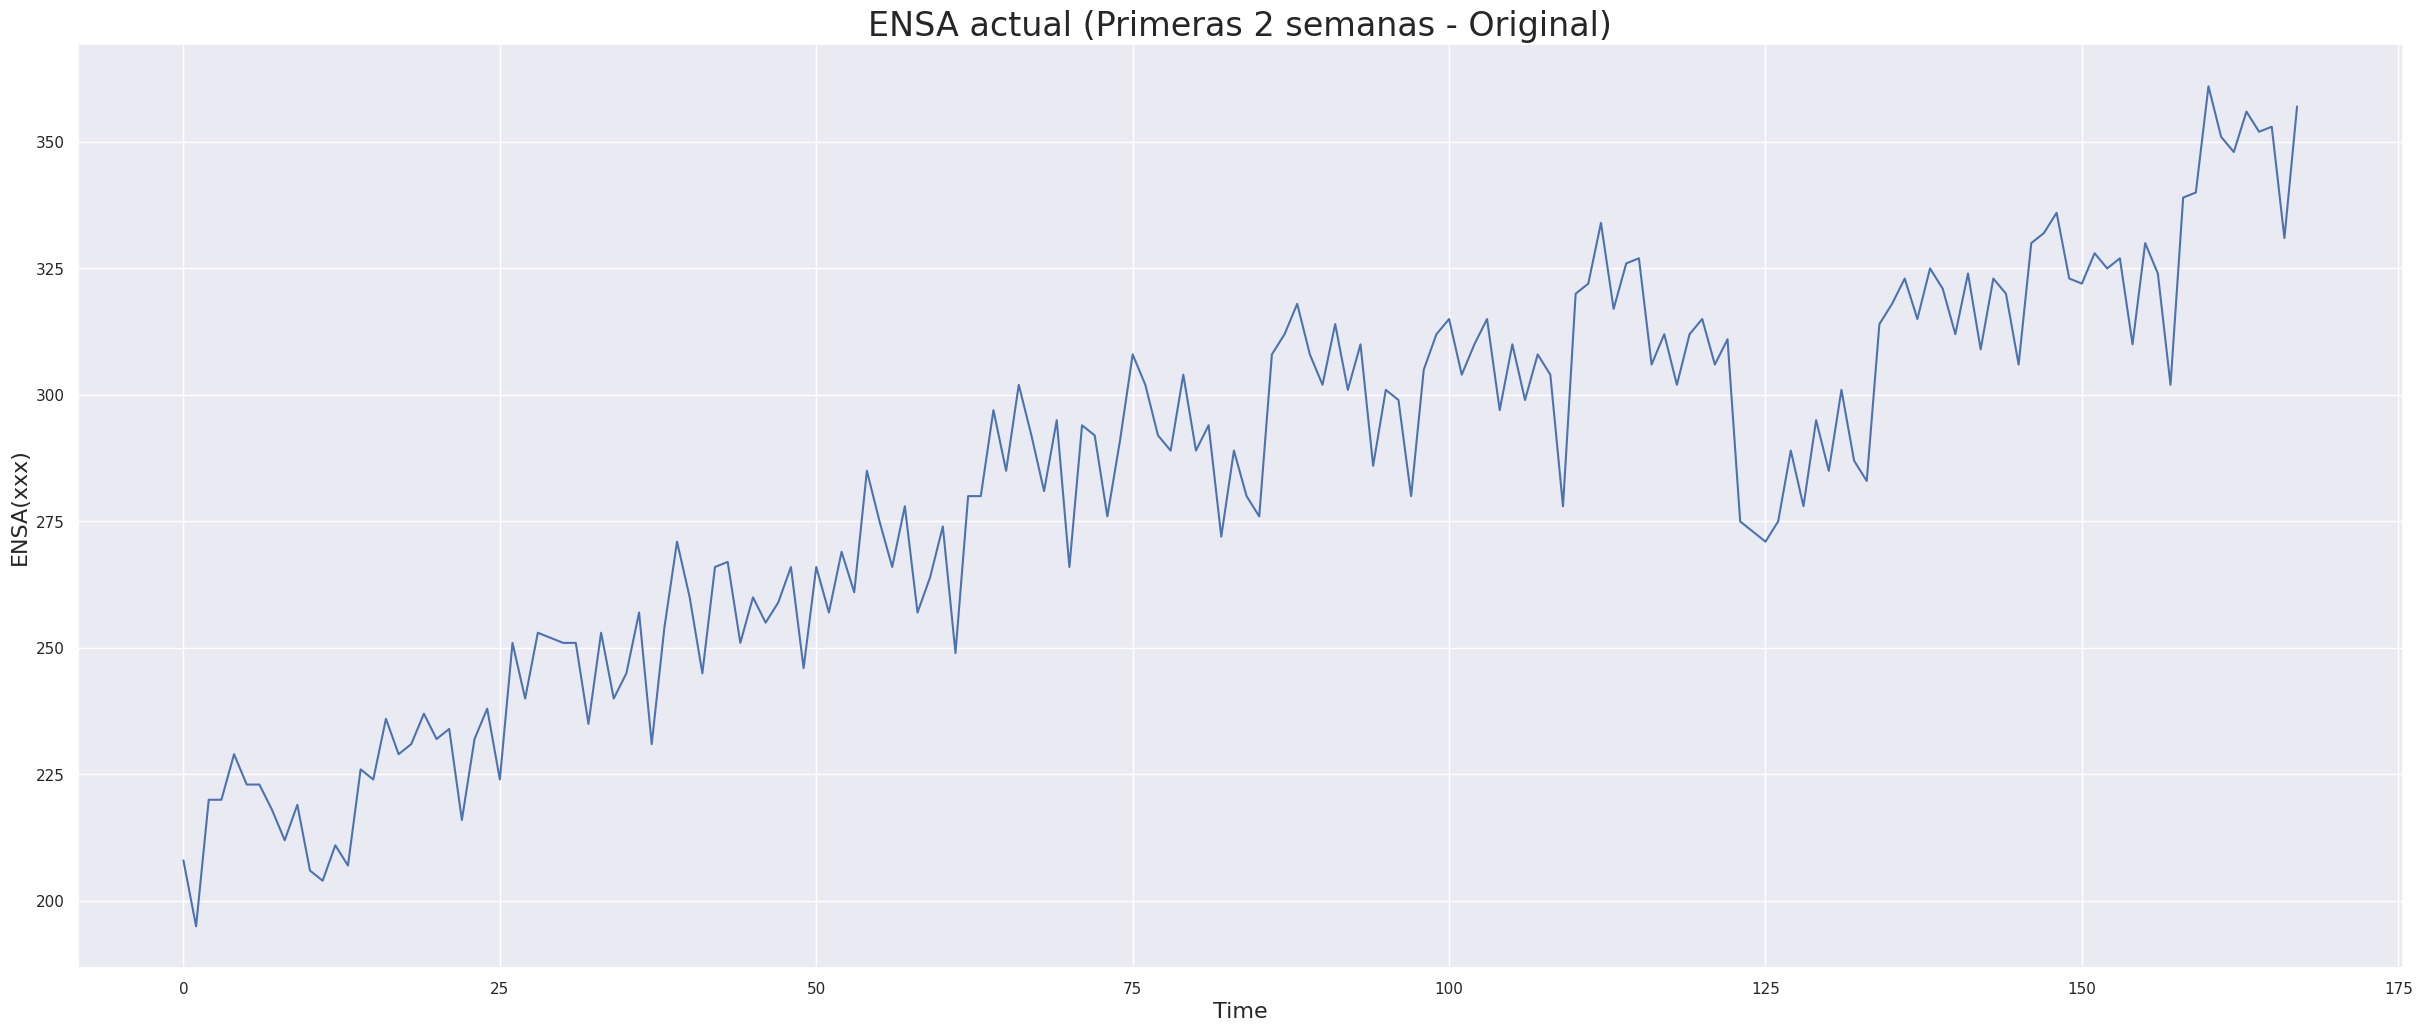

In [ ]:
ax = plot_series(df=datos_Maestro, column='ENSA', ylabel='ENSA(xxx)',
                 title='ENSA actual (Primeras 2 semanas - Original)', end=24*7*2)
plt.show()

In [ ]:
# Borrar columnas con informacion metereologica cualitativa
datos_Maestro = datos_Maestro.drop(['dummy'], axis=1)

In [ ]:
datos_Maestro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fecha              168 non-null    datetime64[ns]
 1   oni                168 non-null    float64       
 2   PIB_real           168 non-null    float64       
 3   PIB_(%)_real       168 non-null    float64       
 4   PIB__corriente     168 non-null    float64       
 5   PIB_(%)_corriente  168 non-null    float64       
 6   wti_usd_barril     168 non-null    int64         
 7   hh_usd_mllbtu      168 non-null    float64       
 8   Panama             168 non-null    int64         
 9   ENSA               168 non-null    int64         
dtypes: datetime64[ns](1), float64(6), int64(3)
memory usage: 13.2 KB


In [ ]:
# Estandarización de los datos

# Seleccionar solo columnas numéricas
datos_numericos = datos_Maestro.select_dtypes(include=[np.number])

# Estandarización de los datos numéricos
scaler = StandardScaler()
datos_escalados = scaler.fit_transform(datos_numericos)
datos_escalados = pd.DataFrame(datos_escalados, columns=datos_numericos.columns)

# Añadir de nuevo las columnas no numéricas al DataFrame escalado
for col in datos_Maestro.select_dtypes(exclude=[np.number]).columns:
    datos_escalados[col] = datos_Maestro[col]


In [ ]:
datos_escalados_sort =  datos_escalados.sort_values(by='fecha').copy()
datos_escalados_sort = datos_escalados_sort.set_index('fecha').copy()
datos_escalados_sort

,oni,PIB_real,PIB_(%)_real,PIB__corriente,PIB_(%)_corriente,wti_usd_barril,hh_usd_mllbtu,Panama,ENSA
fecha,,,,,,,,,
2010-01-01,1.711300,-1.079477,0.048562,-1.877258,0.049407,0.285453,1.865147,-1.933230,-1.984154
2010-02-01,1.489379,-1.079477,0.048562,-1.877258,0.049407,0.194368,1.471201,-2.259317,-2.325339
2010-03-01,1.045537,-1.079477,0.048562,-1.877258,0.049407,0.422080,0.683309,-1.484860,-1.669214
2010-04-01,0.490736,-1.079477,0.048562,-1.877258,0.049407,0.558706,0.446941,-1.664208,-1.669214
2010-05-01,-0.064066,-1.079477,0.048562,-1.877258,0.049407,0.103283,0.525730,-1.484860,-1.433009
...,...,...,...,...,...,...,...,...,...
2023-08-01,1.489379,2.474139,0.184536,1.516739,0.049407,0.422080,-0.656108,1.857531,1.900107
2023-09-01,1.822260,2.474139,0.184536,1.516739,0.049407,0.786418,-0.656108,1.564053,1.795127
2023-10-01,2.044181,2.474139,0.184536,1.516739,0.049407,0.649791,-0.340951,1.824922,1.821372


In [ ]:
# Preparar datos para LSTM
window_size = 24
X = []
y = []

for i in range(window_size, len(datos_escalados_sort) - 12):  # -12 para predecir el año completo de 2024
    X.append(datos_escalados_sort.iloc[i-window_size:i, :-1].values)  # Todas las variables excepto ENSA
    y.append(datos_escalados_sort.iloc[i, -1])  # La variable ENSA

X, y = np.array(X), np.array(y)

In [ ]:
# División en entrenamiento y validación
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [ ]:
# Definir la arquitectura LSTM
model = Sequential([
    InputLayer((window_size, datos_escalados_sort.shape[1]-1)),
    #InputLayer((window_size,1)),
    LSTM(150, activation='relu'), # 5
    Dense(130, activation='tanh'), # 2
    Dense(1, activation='linear')
])

In [ ]:
# Definir la arquitectura GRU
#model = Sequential([
    #InputLayer(input_shape=(window_size, datos_numericos.shape[1] - 1)),
    #GRU(50, activation='relu', return_sequences=True),
    #GRU(50, activation='relu'),
    #Dense(20, activation='relu'),
    #Dense(1)
#])

In [ ]:
# Compilar y entrenar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
4/4 [==============================] - 2s 137ms/step - loss: 0.4203 - val_loss: 0.8462
Epoch 2/100
4/4 [==============================] - 0s 49ms/step - loss: 0.1513 - val_loss: 0.7057
Epoch 3/100
4/4 [==============================] - 0s 39ms/step - loss: 0.1147 - val_loss: 0.3451
Epoch 4/100
4/4 [==============================] - 0s 40ms/step - loss: 0.0938 - val_loss: 0.2266
Epoch 5/100
4/4 [==============================] - 0s 41ms/step - loss: 0.0989 - val_loss: 0.2056
Epoch 6/100
4/4 [==============================] - 0s 43ms/step - loss: 0.0859 - val_loss: 0.1819
Epoch 7/100
4/4 [==============================] - 0s 40ms/step - loss: 0.0826 - val_loss: 0.2883
Epoch 8/100
4/4 [==============================] - 0s 45ms/step - loss: 0.0809 - val_loss: 0.2452
Epoch 9/100
4/4 [==============================] - 0s 42ms/step - loss: 0.0767 - val_loss: 0.1429
Epoch 10/100
4/4 [==============================] - 0s 38ms/step - loss: 0.0793 - val_loss: 0.1328
Epoch 11/100
4/4 [

In [ ]:
# Generar predicciones para 2024 (esto requiere datos futuros que podríamos simular o extender en base a los últimos datos disponibles)


# **Pasos a seguir**

**Generación de características futuras:** como el modelo depende de entradas que necesitamos prever (como las temperaturas futuras), necesitamos estimar o simular estos datos para 2024.

**Extensión del conjunto de datos:** Extendiendo los datos hasta junio de 2024, asumiendo ciertas tendencias o repitiendo patrones anteriores si no hay mejor estimación disponible.

**Predicción con el modelo:** Utilizar el modelo para hacer las predicciones basadas en estas entradas extendidas o simuladas.

In [ ]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt

In [ ]:
periodos_pronostico = 6

# Simular datos futuros para las características necesarias basándonos en las últimas observaciones
last_date = datos_Maestro['fecha'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=periodos_pronostico, freq='M')

In [ ]:
# Asumiendo que la tendencia de las características numéricas se mantiene constante
future_data = []
for date in future_dates:
    last_row = datos_numericos.iloc[-1].copy()
    last_row.name = date
    future_data.append(last_row)

future_df = pd.DataFrame(future_data)

In [ ]:
# Concatenar los datos simulados con los datos originales
extended_data = pd.concat([datos_numericos, future_df])
extended_index_ultimos_6 = extended_data.tail(periodos_pronostico).index
extended_data

,oni,PIB_real,PIB_(%)_real,PIB__corriente,PIB_(%)_corriente,wti_usd_barril,hh_usd_mllbtu,Panama,ENSA
0,1.5,25.066,0.06,29.440,0.09,78.0,5.8,569.0,208.0
1,1.3,25.066,0.06,29.440,0.09,76.0,5.3,529.0,195.0
2,0.9,25.066,0.06,29.440,0.09,81.0,4.3,624.0,220.0
3,0.4,25.066,0.06,29.440,0.09,84.0,4.0,602.0,220.0
4,-0.1,25.066,0.06,29.440,0.09,74.0,4.1,624.0,229.0
...,...,...,...,...,...,...,...,...,...
2024-01-31 00:00:00,2.0,78.591,0.07,76.523,0.09,72.0,2.5,1043.0,357.0
2024-02-29 00:00:00,2.0,78.591,0.07,76.523,0.09,72.0,2.5,1043.0,357.0
2024-03-31 00:00:00,2.0,78.591,0.07,76.523,0.09,72.0,2.5,1043.0,357.0
2024-04-30 00:00:00,2.0,78.591,0.07,76.523,0.09,72.0,2.5,1043.0,357.0


In [ ]:
extended_index = extended_data.tail(periodos_pronostico).index


In [ ]:
# Escalar los datos extendidos
extended_scaled = scaler.transform(extended_data)
extended_scaled_df = pd.DataFrame(extended_scaled, columns=extended_data.columns) #, index=extended_index)


In [ ]:
# Preparar datos para LSTM incluyendo los futuros
X_extended = []
y_extended = []

for i in range(window_size, len(extended_scaled_df)-periodos_pronostico):  # Preparar hasta junio de 2024
    X_extended.append(extended_scaled_df.iloc[i-window_size:i, :-1].values)  # Excluir ENSA
    y_extended.append(extended_scaled_df.iloc[i, -1])  # Incluir ENSA

X_extended = np.array(X_extended)
y_extended = np.array(y_extended)

In [ ]:
# Predicciones para los primeros 6 meses de 2024
predictions = model.predict(X_extended[-periodos_pronostico:])  # Últimos 6 registros para predicción

1/1 [==============================] - 0s 332ms/step


In [ ]:
predictions_series = pd.Series(predictions[:, 0], name='Predictions')
predictions_series

0    1.273658
1    1.203481
2    1.344029
3    1.711155
4    1.871035
5    2.038910
Name: Predictions, dtype: float32

In [ ]:
df_with_predictions = pd.concat([extended_scaled_df.tail(6).reset_index(), predictions_series], axis=1)
df_with_predictions_2 = df_with_predictions.set_index('index')
df_with_predictions_3=df_with_predictions_2.drop('ENSA',axis = 1)
df_with_predictions_4 = df_with_predictions_3.rename(columns= {'Predictions':'ENSA'})
df_with_predictions_4

,oni,PIB_real,PIB_(%)_real,PIB__corriente,PIB_(%)_corriente,wti_usd_barril,hh_usd_mllbtu,Panama,ENSA
index,,,,,,,,,
168,2.266102,2.474139,0.184536,1.516739,0.049407,0.012199,-0.734897,1.930901,1.273658
169,2.266102,2.474139,0.184536,1.516739,0.049407,0.012199,-0.734897,1.930901,1.203481
170,2.266102,2.474139,0.184536,1.516739,0.049407,0.012199,-0.734897,1.930901,1.344029
171,2.266102,2.474139,0.184536,1.516739,0.049407,0.012199,-0.734897,1.930901,1.711155
172,2.266102,2.474139,0.184536,1.516739,0.049407,0.012199,-0.734897,1.930901,1.871035
173,2.266102,2.474139,0.184536,1.516739,0.049407,0.012199,-0.734897,1.930901,2.038910


In [ ]:
df_index = pd.DataFrame({'fecha': extended_index},index =df_with_predictions_4.index )


In [ ]:

# Devolver las predicciones a la escala original
original_predictions = scaler.inverse_transform(df_with_predictions_4)
original_predictions
df_pronostico = pd.DataFrame(original_predictions, columns=df_with_predictions_4.columns, index=df_with_predictions_4.index)
df_pronostico_final = pd.concat([df_pronostico,df_index],axis=1)


In [ ]:
# Mostrar las predicciones
print(f"Predicciones de ENSA para los primeros {periodos_pronostico} meses de 2024:")
print(predictions.flatten())


Predicciones de ENSA para los primeros 6 meses de 2024:
[1.2736582 1.2034814 1.3440293 1.7111552 1.8710352 2.0389097]


**Supongamos que 'predictions' es el array obtenido de las predicciones anteriores**
**y 'future_dates' contiene las fechas correspondientes a estas predicciones**

In [ ]:
# Crear un DataFrame para las predicciones
predictions_df = pd.DataFrame({
    'fecha': future_dates,
    'ENSA_pred': predictions.flatten()
})
predictions_df = predictions_df.set_index('fecha')

In [ ]:
# Filtrar los datos desde 2022 para visualizar ######################################
historical_data = datos_Maestro[(datos_Maestro['fecha'] >= '2022-01-01') & (datos_Maestro['fecha'] <= last_date)]
historical_data = historical_data[['fecha', 'ENSA']]


In [ ]:
historical_data_pronostico = df_pronostico_final[['fecha', 'ENSA']]
historical_data_pronostico

,fecha,ENSA
index,,
168,2023-12-31,332.130730
169,2024-01-31,329.456823
170,2024-02-29,334.812046
171,2024-03-31,348.800453
172,2024-04-30,354.892280
173,2024-05-31,361.288714


In [ ]:
combined_data = pd.concat([historical_data, historical_data_pronostico])
#combined_data


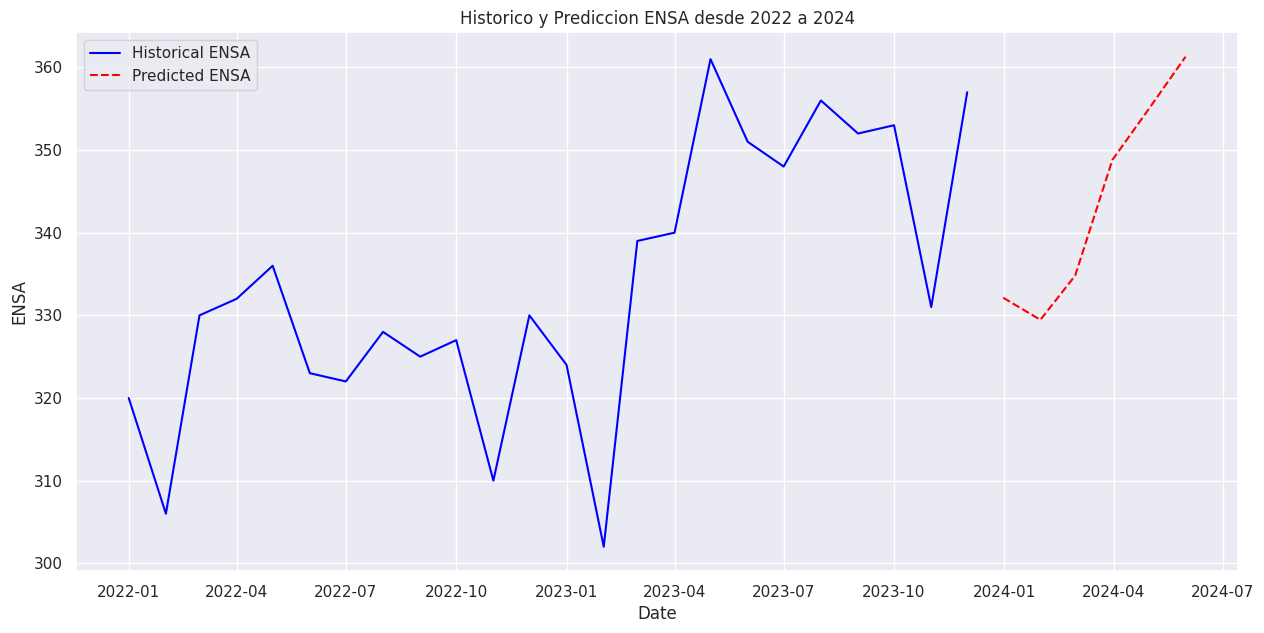

In [ ]:
# Graficar los resultados #######################################################
plt.figure(figsize=(15, 7))
plt.plot(combined_data['fecha'][:-periodos_pronostico], combined_data['ENSA'][:-periodos_pronostico], label='Historical ENSA', color='blue')
plt.plot(combined_data['fecha'].tail(periodos_pronostico), combined_data['ENSA'].tail(periodos_pronostico), label='Predicted ENSA', color='red', linestyle='--')
plt.title('Historico y Prediccion ENSA desde 2022 a 2024')
plt.xlabel('Date')
plt.ylabel('ENSA')
plt.legend()
plt.grid(True)
plt.show()


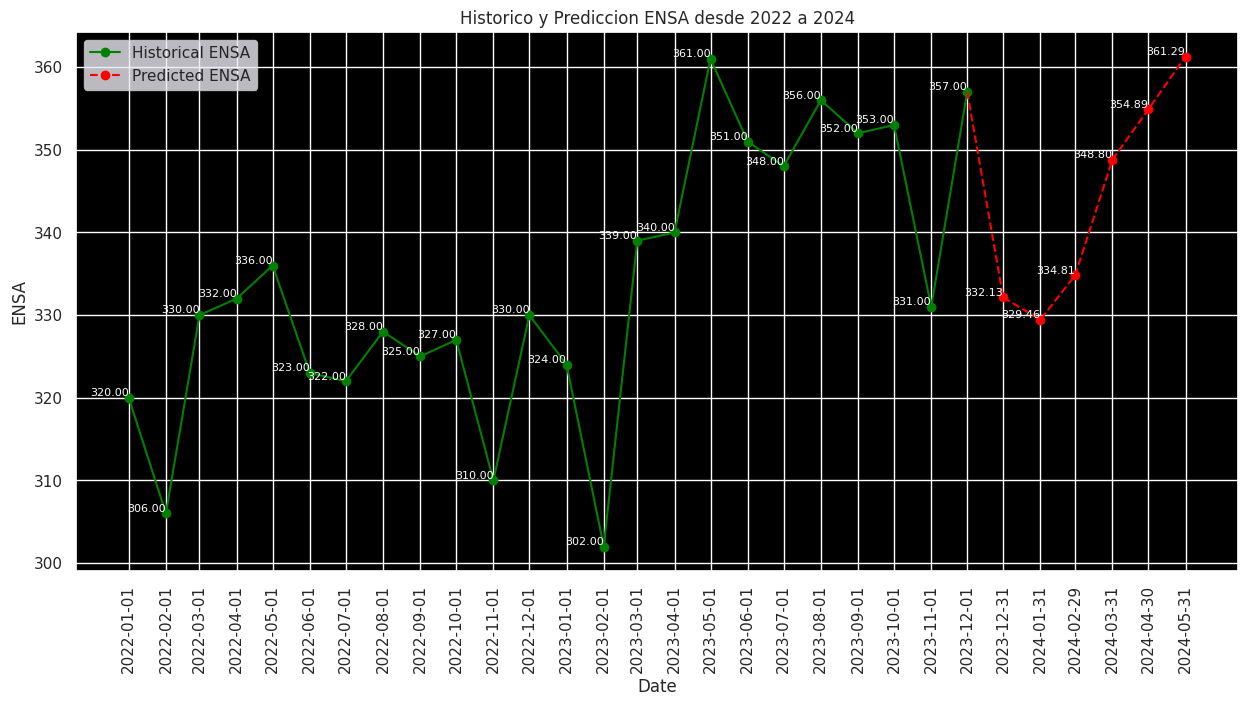

In [ ]:

# Graficar los resultados
plt.figure(figsize=(15, 7))

# Graficar la serie histórica con puntos verdes y etiquetas de valores
historical = combined_data['ENSA'][:-periodos_pronostico]
plt.plot(combined_data['fecha'][:-periodos_pronostico], historical, label='Historical ENSA', color='green', marker='o')
for i, valor in enumerate(historical):
    plt.text(combined_data['fecha'].iloc[i], valor, f'{valor:.2f}', color='white', fontsize=8, ha='right', va='bottom')

# Graficar la serie pronosticada con puntos rojos y etiquetas de valores
predicted = combined_data['ENSA'].tail(periodos_pronostico)
plt.plot(combined_data['fecha'].tail(periodos_pronostico), predicted, label='Predicted ENSA', color='red', linestyle='--', marker='o')
for i, valor in enumerate(predicted):
    plt.text(combined_data['fecha'].iloc[-periodos_pronostico + i], valor, f'{valor:.2f}', color='white', fontsize=8, ha='right', va='bottom')

# Agregar línea que une los puntos verdes y rojos
plt.plot([combined_data['fecha'][:-periodos_pronostico].iloc[-1], combined_data['fecha'].tail(periodos_pronostico).iloc[0]],
         [combined_data['ENSA'][:-periodos_pronostico].iloc[-1], combined_data['ENSA'].tail(periodos_pronostico).iloc[0]],
         color='red',linestyle='--')

# Establecer el título y etiquetas de los ejes
plt.title('Historico y Prediccion ENSA desde 2022 a 2024')
plt.xlabel('Date')
plt.ylabel('ENSA')

# Rotar los títulos del eje x para que se vean todos
plt.xticks(rotation=90)

# Ajustar los ticks del eje x para mostrar más divisiones
plt.xticks(combined_data['fecha'], rotation=90)

# Mostrar la leyenda
plt.legend()

# Establecer el fondo negro y agregar cuadrícula
plt.gca().set_facecolor('black')
plt.grid(True, color='white')

# Mostrar la gráfica
plt.show()